## Importación de librerías

In [74]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Configuración de variables globales

In [22]:
with open('setup.json', 'r') as f:
    SETUP_JSON = json.load(f)
OUTPUT_PARQUET = SETUP_JSON['dataset_parquet'] # Output Parquet file

## Cargar el dataset

In [23]:
df = pd.read_parquet(OUTPUT_PARQUET) # Leer Parquet
df.shape

(897609, 81)

## Extracción de secuencias de paquetes

Obtener todas las secuencias de paquetes presentes en el dataset.

In [24]:
# Crear una copia del DataFrame original para no modificarlo directamente.
df_temp = df.copy()

# Cada vez que el valor de 'label' cambia, se incrementa el contador acumulativo.
df_temp['Sequence'] = (df_temp['Label'] != df_temp['Label'].shift()).cumsum()

# Agrupar el DataFrame por la columna 'sequence' y crear una lista de DataFrames.
sequences = [sequence for _, sequence in df_temp.groupby('Sequence')]  

for sequence_df in sequences:  # Iterar sobre cada DataFrame en la lista de secuencias.
    # Eliminar la columna 'sequence' de cada DataFrame, ya que solo se usó para agrupar.
    sequence_df.drop(columns='Sequence', inplace=True)  
    # Reiniciar los índices de cada DataFrame para que comiencen desde 0.
    sequence_df.reset_index(drop=True, inplace=True)

## Análisis de las secuencias

In [25]:
print(f"Total de secuencias de paquetes encontradas: {len(sequences)}")

Total de secuencias de paquetes encontradas: 16379


In [26]:
print(f"Primera secuencia: {sequences[0]['Label'].unique()}")
print(f"Número de paquetes de la primera secuencia: {sequences[0].shape[0]}")

Primera secuencia: ['Benign']
Número de paquetes de la primera secuencia: 94


In [27]:
print(f"Última secuencia: {sequences[-1]['Label'].unique()}")
print(f"Número de paquetes de la última secuencia: {sequences[-1].shape[0]}")

Última secuencia: ['Bot']
Número de paquetes de la última secuencia: 121


In [28]:
sequences_df = pd.DataFrame({
    'Sequence Size': [sequence.shape[0] for sequence in sequences],
    'Sequence Label': [sequence['Label'].unique()[0] for sequence in sequences]
})

In [29]:
sequences_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16379 entries, 0 to 16378
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Sequence Size   16379 non-null  int64 
 1   Sequence Label  16379 non-null  object
dtypes: int64(1), object(1)
memory usage: 256.1+ KB


In [30]:
sequences_df.head()

,Sequence Size,Sequence Label
0,94,Benign
1,64,FTP-BruteForce
2,1,Benign
3,5610,FTP-BruteForce
4,1,Benign


In [31]:
print("Análisis estadístico de las secuencias")
print(f"{sequences_df['Sequence Size'].describe()}")

Análisis estadístico de las secuencias
count     16379.000000
mean         54.802430
std        2525.859106
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max      297085.000000
Name: Sequence Size, dtype: float64


Obtener media y desviación estándar del número de paquetes.

In [32]:
# Obtener la media de paquetes por secuencia
mean = sequences_df['Sequence Size'].mean()

# Obtener la desviación estándar muestral (por defecto ddof=1)
deviation = sequences_df['Sequence Size'].std()

print(f"Número promedio de paquetes por secuencia: {mean}")
print(f"Desviación estándar (muestral): {deviation}")

Número promedio de paquetes por secuencia: 54.80242994077783
Desviación estándar (muestral): 2525.859105521642


Obtener número de secuencias asociadas a cada etiqueta

In [33]:
sequences_df["Sequence Label"].value_counts()  # Contar la cantidad de secuencias por etiqueta

Sequence Label
DoS attacks-GoldenEye       5026
DoS attacks-Slowloris       4668
Benign                      4021
Bot                         1753
DDOS attack-LOIC-UDP         635
Brute Force -XSS             109
Brute Force -Web              73
DoS attacks-SlowHTTPTest      34
SQL Injection                 32
FTP-BruteForce                22
DDOS attack-HOIC               5
DoS attacks-Hulk               1
Name: count, dtype: int64

In [34]:
# Número de características de cada secuencia
num_features = sequences[0].shape[1] - 2
# Número de etiquetas únicas
num_labels = len(sequences_df["Sequence Label"].unique())
# Número de secuencias
num_sequences = len(sequences)
# Media de paquetes por secuencia como longitud fija
sequence_length = int(mean)

In [35]:
print(f"Número de características: {num_features}")
print(f"Número de secuencias: {num_sequences}")
print(f"Número de etiquetas únicas: {num_labels}")
print(f"Longitud de cada secuencia: {sequence_length}")

Número de características: 79
Número de secuencias: 16379
Número de etiquetas únicas: 12
Longitud de cada secuencia: 54


## Separación de datos

In [36]:
X = []
y = []

for seq in sequences:
    sequence_X = seq.drop(columns=['Label', 'Label Code']) # Obtener las características
    sequence_Y = seq['Label Code'].iloc[0] # Obtener la etiqueta

    if len(sequence_X) < sequence_length:
        # Rellenar con ceros
        pad_width = sequence_length - len(sequence_X)
        sequence_X = np.pad(sequence_X, ((0, pad_width), (0, 0)), mode='constant')
    else:
        # Recortar
        sequence_X = sequence_X.iloc[:sequence_length]

    X.append(sequence_X)
    y.append(sequence_Y)

X = np.array(X)
y = np.array(y)

In [37]:
print(X.shape)
print(y.shape)

(16379, 54, 79)
(16379,)


Escalamiento de características

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, num_features)).reshape(num_sequences, sequence_length, num_features)

## Separar secuencias en entrenamiento, validación y prueba

Eliminar clases con menos de 2 ejemplos

In [78]:
# Contar ejemplos por clase
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))

# Filtrar clases con al menos 2 instancias
valid_classes = [cls for cls, count in class_counts.items() if count >= 2]

# Filtrar datos
mask = np.isin(y, valid_classes)
X_filtered = X_scaled[mask]
y_filtered = y[mask]

In [79]:
X_filtered.shape, y_filtered.shape

((16378, 54, 79), (16378,))

Separación de datos

In [ ]:
# Separar en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, stratify=y_filtered)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [81]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(10481, 54, 79) (10481,)
(2621, 54, 79) (2621,)
(3276, 54, 79) (3276,)


Convertir los arrays a tensores

In [82]:
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

## Inicialización del modelo

In [83]:
# Modelo LSTM
class NetFlowLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)         # h_n shape: (1, batch, hidden)
        return self.classifier(h_n[-1])    # usar último estado oculto

model = NetFlowLSTM(input_dim=num_features, hidden_dim=32, output_dim=num_labels)

## Entrenamiento

In [84]:
# Configurar entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 200

In [85]:
# Función de evaluación
def evaluate_model(model, X_tensor, y_tensor):
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        pred = torch.argmax(outputs, dim=1)
        acc = (pred == y_tensor).float().mean().item()
    return loss, acc

In [86]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # --- ENTRENAMIENTO ---
    model.train()
    optimizer.zero_grad()

    outputs = model(X_val_tensor)
    loss = criterion(outputs, y_val_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())  # Guarda la pérdida de entrenamiento

    # --- VALIDACIÓN ---
    model.eval()
    val_loss, val_acc = evaluate_model(model, X_val_tensor, y_val_tensor)
    val_losses.append(val_loss.item())  # Guarda pérdida validación
    val_accuracies.append(val_acc)      # Guarda precisión validación

    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch+1:02d} | Pérdida ent.: {loss.item():.4f} | Pérdida val.: {val_loss.item():.4f} | Precisión val.: {val_acc:.2f}")

Época 10 | Pérdida ent.: 1.5195 | Pérdida val.: 1.5166 | Precisión val.: 0.27
Época 20 | Pérdida ent.: 1.4565 | Pérdida val.: 1.4522 | Precisión val.: 0.33
Época 30 | Pérdida ent.: 1.3351 | Pérdida val.: 1.3124 | Precisión val.: 0.40
Época 40 | Pérdida ent.: 1.2005 | Pérdida val.: 1.1936 | Precisión val.: 0.42
Época 50 | Pérdida ent.: 1.1651 | Pérdida val.: 1.1659 | Precisión val.: 0.43
Época 60 | Pérdida ent.: 1.2232 | Pérdida val.: 1.2086 | Precisión val.: 0.41
Época 70 | Pérdida ent.: 1.1030 | Pérdida val.: 1.0891 | Precisión val.: 0.74
Época 80 | Pérdida ent.: 0.7967 | Pérdida val.: 0.7560 | Precisión val.: 0.86
Época 90 | Pérdida ent.: 0.4277 | Pérdida val.: 0.4059 | Precisión val.: 0.92
Época 100 | Pérdida ent.: 0.2633 | Pérdida val.: 0.3715 | Precisión val.: 0.93
Época 110 | Pérdida ent.: 0.2097 | Pérdida val.: 0.2077 | Precisión val.: 0.96
Época 120 | Pérdida ent.: 0.1862 | Pérdida val.: 0.1707 | Precisión val.: 0.98
Época 130 | Pérdida ent.: 0.1263 | Pérdida val.: 0.1204 | Pre

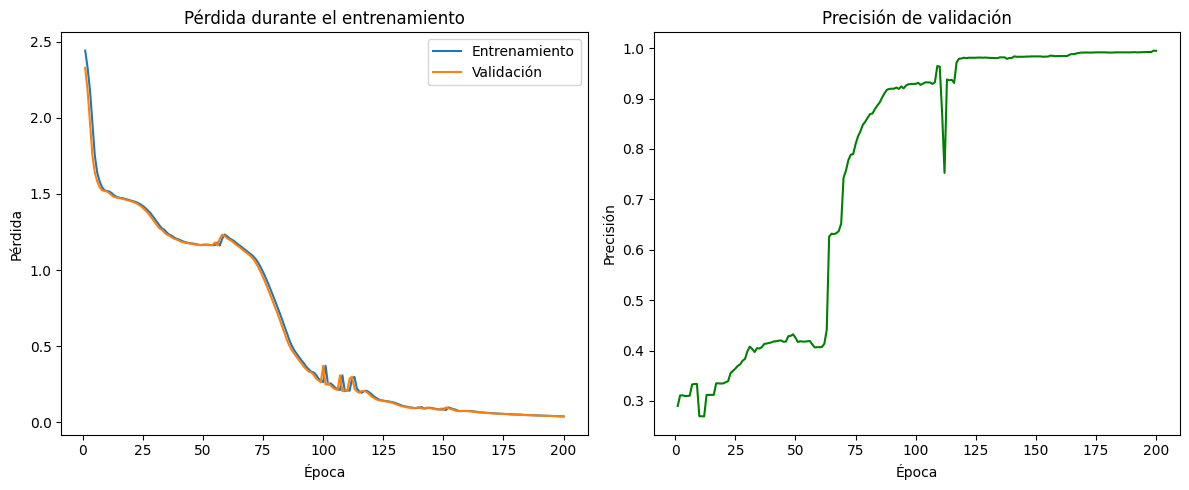

In [87]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Pérdidas
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Entrenamiento')
plt.plot(epochs_range, val_losses, label='Validación')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida durante el entrenamiento")
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, color='green')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Precisión de validación")

plt.tight_layout()
plt.show()


## Evaluación

In [88]:
model.eval()
test_loss, test_acc = evaluate_model(model, X_test_tensor, y_test_tensor)

print(f"\n🔍 Evaluación final en test:")
print(f"Pérdida en test: {test_loss.item():.4f}")
print(f"Precisión en test: {test_acc:.2f}")


🔍 Evaluación final en test:
Pérdida en test: 0.1030
Precisión en test: 0.98


## Visualización de la predicción

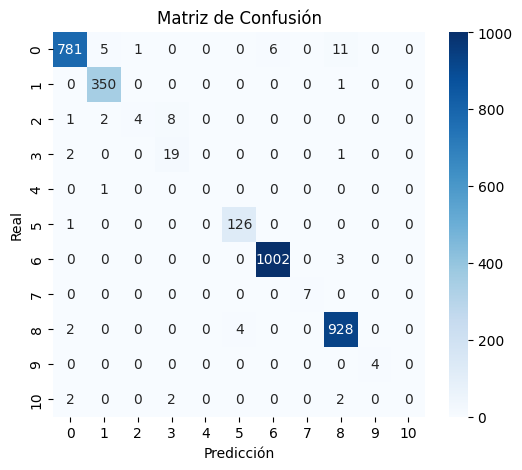

In [ ]:
# Obtener predicciones del modelo
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    preds = torch.argmax(outputs, dim=1)

# Convertir tensores a NumPy (si es necesario)
y_true = y_test_tensor.numpy()
y_pred = preds.numpy()

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
"""# Asignar la columna 'ID' dentro de cada DataFrame en train
for i, sequence in enumerate(train["Sequence"]):
    sequence["ID"] = train.iloc[i]["ID"]
# Asignar la columna 'ID' dentro de cada DataFrame en train
for i, sequence in enumerate(test["Sequence"]):
    sequence["ID"] = test.iloc[i]["ID"]


# Concatenar manteniendo la columna 'ID'
train_concatenado = pd.concat(train["Sequence"].tolist(), ignore_index=True)
# Concatenar manteniendo la columna 'ID'
test_concatenado = pd.concat(test["Sequence"].tolist(), ignore_index=True)"""

'# Asignar la columna \'ID\' dentro de cada DataFrame en train\nfor i, sequence in enumerate(train["Sequence"]):\n    sequence["ID"] = train.iloc[i]["ID"]\n# Asignar la columna \'ID\' dentro de cada DataFrame en train\nfor i, sequence in enumerate(test["Sequence"]):\n    sequence["ID"] = test.iloc[i]["ID"]\n\n\n# Concatenar manteniendo la columna \'ID\'\ntrain_concatenado = pd.concat(train["Sequence"].tolist(), ignore_index=True)\n# Concatenar manteniendo la columna \'ID\'\ntest_concatenado = pd.concat(test["Sequence"].tolist(), ignore_index=True)'

In [ ]:
"""# Dividir los DataFrames en características (X) y etiquetas (y)
x_train = train_concatenado.drop(columns=['Label', 'ID'])
y_train = train_concatenado[['Label', 'ID']]
# Crear la nueva columna basada en el mapeo
y_train['Label_Mapped'] = y_train['Label'].map(LABELS)

x_test = test_concatenado.drop(columns=['Label', 'ID'])
y_test = test_concatenado[['Label', 'ID']]
# Crear la nueva columna basada en el mapeo
y_test['Label_Mapped'] = y_test['Label'].map(LABELS)

print(f"Dimensiones de x_train: {x_train.shape}")
print(y_train[['Label']].value_counts()) 
y_train.head() # Muestra los primeros 5 paquetes del dataframe de entrenamiento"""

'# Dividir los DataFrames en características (X) y etiquetas (y)\nx_train = train_concatenado.drop(columns=[\'Label\', \'ID\'])\ny_train = train_concatenado[[\'Label\', \'ID\']]\n# Crear la nueva columna basada en el mapeo\ny_train[\'Label_Mapped\'] = y_train[\'Label\'].map(LABELS)\n\nx_test = test_concatenado.drop(columns=[\'Label\', \'ID\'])\ny_test = test_concatenado[[\'Label\', \'ID\']]\n# Crear la nueva columna basada en el mapeo\ny_test[\'Label_Mapped\'] = y_test[\'Label\'].map(LABELS)\n\nprint(f"Dimensiones de x_train: {x_train.shape}")\nprint(y_train[[\'Label\']].value_counts()) \ny_train.head() # Muestra los primeros 5 paquetes del dataframe de entrenamiento'

In [ ]:
# Cambiar etiquetas a su estado original
"""original_labels = le.inverse_transform(sequences[-1]['Label'])
print(original_labels)
print(len(original_labels))"""

"original_labels = le.inverse_transform(sequences[-1]['Label'])\nprint(original_labels)\nprint(len(original_labels))"